In [2]:
import jax

jax.config.update("jax_enable_x64", val=True)
NORO_FACTOR = 100 * 1.07 / 2.84

In [5]:
import jax.numpy as jnp
from jax import jit, vmap

from qpm import cwes, mgoslt


def build_simulation_inputs(
    total_length: float,
    shg_domain_width: float,
    sfg_domain_width: float,
    max_total_domains: int,
    kappa_mag: float,
) -> tuple[jax.Array, jax.Array, jax.Array, jax.Array]:
    """Generates batched inputs for every valid SHG/SFG domain configuration."""
    # 1. Generate all potential domain counts
    shg_counts = jnp.arange(jnp.floor(total_length / shg_domain_width).astype(jnp.int32) + 1)
    sfg_counts = jnp.floor((total_length - shg_counts * shg_domain_width) / sfg_domain_width).astype(jnp.int32)
    total_counts = shg_counts + sfg_counts

    # 2. Filter for valid configurations where there's at least one domain
    valid_mask = (sfg_counts >= 0) & (total_counts > 0)
    shg_counts, sfg_counts, total_counts = shg_counts[valid_mask], sfg_counts[valid_mask], total_counts[valid_mask]

    # 3. Build batched inputs using vectorized operations
    domain_indices = jnp.arange(max_total_domains)
    is_shg_domain = domain_indices < shg_counts[:, None]
    is_sfg_domain = (domain_indices >= shg_counts[:, None]) & (domain_indices < total_counts[:, None])
    is_active_domain = domain_indices < total_counts[:, None]

    # REFACTOR: Nested jnp.where is more concise than sequential assignments.
    batched_widths = jnp.where(is_shg_domain, shg_domain_width, jnp.where(is_sfg_domain, sfg_domain_width, 0.0))

    base_kappas = kappa_mag * jnp.power(-1, domain_indices)
    batched_kappa_vals = jnp.where(is_active_domain, base_kappas, 0.0)

    return batched_widths, batched_kappa_vals, shg_counts, sfg_counts


# --- Simulation Parameters ---
total_length = 2.3e3  # µm
design_wl = 1.031
design_temp = 70.0
kappa_mag = 1.31e-5 / (2 / jnp.pi)
b_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex128)

# --- Core Logic ---
delta_k1_design = mgoslt.calc_twm_delta_k(design_wl, design_wl, design_temp)
delta_k2_design = mgoslt.calc_twm_delta_k(design_wl, design_wl / 2, design_temp)
shg_domain_width = jnp.pi / delta_k1_design
sfg_domain_width = jnp.pi / delta_k2_design

# 1. Generate all inputs in a single vectorized operation
max_total_domains = int(total_length / sfg_domain_width)
batched_widths, batched_kappa_vals, shg_counts, sfg_counts = build_simulation_inputs(
    total_length, shg_domain_width, sfg_domain_width, max_total_domains, kappa_mag
)

# 2. Run batched simulations
batched_simulate = jit(vmap(cwes.simulate_twm, in_axes=(0, 0, None, None, None)))
b_finals = batched_simulate(batched_widths, batched_kappa_vals, delta_k1_design, delta_k2_design, b_initial)
thg_powers = jnp.abs(b_finals[:, 2]) ** 2 * NORO_FACTOR
thg_powers.block_until_ready()

# 3. Analyze and display the final results
best_idx = jnp.argmax(thg_powers)
max_power = thg_powers[best_idx]
optimal_num_shg = shg_counts[best_idx]
optimal_num_sfg = sfg_counts[best_idx]

optimal_shg_length = optimal_num_shg * shg_domain_width
optimal_sfg_length = optimal_num_sfg * sfg_domain_width
actual_total_length = optimal_shg_length + optimal_sfg_length
optimal_ratio = optimal_shg_length / actual_total_length

print(f"Total Device Length: {total_length:.2f} µm")
print("---")
print(f"Optimal SHG/Total Length Ratio: {optimal_ratio:.4f}")
print(f"Optimal SHG Domains: {optimal_num_shg}")
print(f"Optimal SFG Domains: {optimal_num_sfg}")
print(f"Actual Device Length in Optimal Config: {actual_total_length:.2f} µm")
print(f"Max Power: {max_power}")

Total Device Length: 2300.00 µm
---
Optimal SHG/Total Length Ratio: 0.5026
Optimal SHG Domains: 321
Optimal SFG Domains: 1168
Actual Device Length in Optimal Config: 2299.99 µm
Max Power: 1.7450096163864338e-05


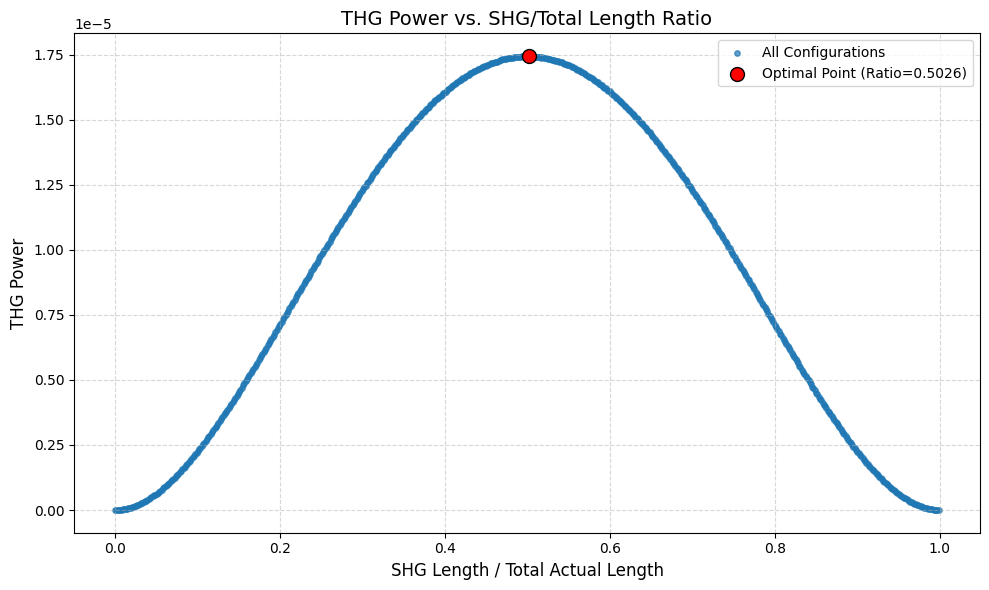

In [8]:
import matplotlib.pyplot as plt


def plot_thg_dependence(
    thg_powers: jax.Array, shg_counts: jax.Array, sfg_counts: jax.Array, shg_domain_width: jax.Array, sfg_domain_width: jax.Array, best_idx: jax.Array
) -> None:
    """
    Plots the THG power against the ratio of SHG length to total device length
    for all discrete configurations.
    """

    # 1. Calculate the x-axis (position) variable for all configurations
    shg_lengths = shg_counts * shg_domain_width
    sfg_lengths = sfg_counts * sfg_domain_width
    actual_lengths = shg_lengths + sfg_lengths

    # This ratio represents the "position" or composition of the device
    ratios = shg_lengths / actual_lengths

    # 2. Create the discrete scatter plot
    plt.figure(figsize=(10, 6))

    # Plot all simulated points
    plt.scatter(ratios, thg_powers, alpha=0.7, s=15, label="All Configurations")

    # Highlight the optimal point (the "singularity")
    plt.scatter(
        ratios[best_idx], thg_powers[best_idx], color="red", s=100, edgecolor="black", zorder=5, label=f"Optimal Point (Ratio={ratios[best_idx]:.4f})"
    )

    plt.title("THG Power vs. SHG/Total Length Ratio", fontsize=14)
    plt.xlabel("SHG Length / Total Actual Length", fontsize=12)
    plt.ylabel("THG Power", fontsize=12)
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# --- Call the function ---
# Assumes thg_powers, shg_counts, sfg_counts, shg_domain_width,
# sfg_domain_width, and best_idx exist from the previous cell.
plot_thg_dependence(thg_powers, shg_counts, sfg_counts, shg_domain_width, sfg_domain_width, best_idx)

In [3]:
import jax.numpy as jnp
import plotly.graph_objects as go

batch_simulate_twm = jit(vmap(cwes.simulate_twm, in_axes=(None, None, 0, 0, None)))

widths_shg = jnp.array([shg_domain_width] * int(optimal_num_shg))
widths_sfg = jnp.array([sfg_domain_width] * int(optimal_num_sfg))
periodical_widths = jnp.concatenate([widths_shg, widths_sfg])
optimized_widths = jnp.load("../datasets/optimized_thg_2000_1489_e4.npy")


def plot_domain_widths(optimized_widths: jax.Array, periodic_widths: jax.Array) -> None:
    """Plots the domain widths before and after optimization."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=periodic_widths, name=f"Periodic {jnp.sum(periodic_widths):.1f} µm", line={"dash": "dot"}))
    fig.add_trace(go.Scatter(y=optimized_widths, name=f"Optimized {jnp.sum(optimized_widths):.1f} µm"))
    fig.update_layout(
        title_text="Domain Widths Comparison",
        xaxis_title="Domain Index",
        yaxis_title="Width (μm)",
        template="plotly_white",
    )
    fig.show()


plot_domain_widths(optimized_widths, periodical_widths)

design_wl = 1.031
design_temp = 70.0
kappa_mag = 1.31e-5 / (2 / jnp.pi)
wls = jnp.linspace(1.025, 1.035, 1000)
b_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex128)

delta_k1s = mgoslt.calc_twm_delta_k(wls, wls, 70.0)
delta_k2s = mgoslt.calc_twm_delta_k(wls, wls / 2, 70.0)

kappa_vals = kappa_mag * jnp.power(-1, jnp.arange(periodical_widths.shape[0]))
b_final_periodical = batch_simulate_twm(periodical_widths, kappa_vals, delta_k1s, delta_k2s, b_initial)
thw_powers_periodical = jnp.abs(b_final_periodical[:, 2]) ** 2 * NORO_FACTOR

device_length = jnp.sum(periodical_widths)
print(optimal_num_shg, optimal_num_sfg)
print(f"Device length: {device_length}")
print(f"Max power / (Device length)^2: {jnp.max(thw_powers_periodical) / device_length**2}")

kappa_vals = kappa_mag * jnp.power(-1, jnp.arange(optimized_widths.shape[0]))
b_final_optimized = batch_simulate_twm(optimized_widths, kappa_vals, delta_k1s, delta_k2s, b_initial)
thw_powers_optimized = jnp.abs(b_final_optimized[:, 2]) ** 2 * NORO_FACTOR

fig = go.Figure()
fig.add_trace(go.Scatter(x=wls, y=thw_powers_optimized, mode="lines", name="Optimized Structure"))
fig.add_trace(go.Scatter(x=wls, y=thw_powers_periodical, mode="lines", name="Periodic Structure"))
fig.update_layout(
    title_text="Efficiency Spectrum",
    xaxis_title="Wavelength (μm)",
    yaxis_title="Efficiency (%/W)",
)
fig.show()

device_length = jnp.sum(optimized_widths)
print(f"Device length: {device_length}")
print(f"Max power / (Device length)^2: {jnp.max(thw_powers_optimized) / device_length**2}")

321 1168
Device length: 2299.9929122861477
Max power / (Device length)^2: 3.2976334826955552e-12


Device length: 2299.97314453125
Max power / (Device length)^2: 4.30323275238301e-12


In [4]:
# --- Calculate Propagation Trace for Optimized Structure ---
# Calculate phase mismatches at the design wavelength
delta_k1_design = mgoslt.calc_twm_delta_k(design_wl, design_wl, design_temp)
delta_k2_design = mgoslt.calc_twm_delta_k(design_wl, design_wl / 2, design_temp)

# Generate kappa values for the optimized structure
kappa_vals_optimized = kappa_mag * jnp.power(-1, jnp.arange(optimized_widths.shape[0]))

# Run simulation to get the trace of amplitudes at each domain
_, full_trace = cwes.simulate_twm_with_trace(optimized_widths, kappa_vals_optimized, delta_k1_design, delta_k2_design, b_initial)

# Calculate the propagation distance z
z = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(optimized_widths)])

# Calculate the power for each wave
fw_amp = jnp.abs(full_trace[:, 0])
shw_amp = jnp.abs(full_trace[:, 1])
thw_amp = jnp.abs(full_trace[:, 2])

# Create the plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=z, y=fw_amp, mode="lines", name="FW Power"))
fig.add_trace(go.Scatter(x=z, y=shw_amp, mode="lines", name="SHW Power"))
fig.add_trace(go.Scatter(x=z, y=thw_amp, mode="lines", name="THW Power"))

fig.update_layout(
    title="Wave Propagation in Optimized Structure",
    xaxis_title="Propagation Distance z (μm)",
    yaxis_title="Amplitude (a.u.)",
    template="plotly_white",
    legend_title="Wave",
)
fig.show()